# Machine Learning Engineer: Capstone Project
## Project: Image Recognition for multiple attributes

Image recognition is one of the many applications of Machine Learning, it can solve problems for security purposes, object detection, face detection, healthcare, entertainment, among others. This application has an enormous potential to help our society1, so it is important to find new uses for this tool, improve the current methods and get more accurate and useful insights from it. 

In this project, we will build a Machine Learning Algorithm using CNN to predict from a giving picture if the person is smiling, if is young and if is male or female.


### Content

#### Overall

202,599 number of face images of various celebrities
10,177 unique identities, but names of identities are not given
40 binary attribute annotations per image
5 landmark locations

#### Data Files

- <b>img_align_celeba.zip</b>: All the face images, cropped and aligned
- <b>list_eval_partition.csv</b>: Recommended partitioning of images into training, validation, testing sets. Images 1-162770 are training, 162771-182637 are validation, 182638-202599 are testing
- <b>list_bbox_celeba.csv</b>: Bounding box information for each image. "x_1" and "y_1" represent the upper left point coordinate of bounding box. "width" and "height" represent the width and height of bounding box
- <b>list_landmarks_align_celeba.csv</b>: Image landmarks and their respective coordinates. There are 5 landmarks: left eye, right eye, nose, left mouth, right mouth
- <b>list_attr_celeba.csv</b>: Attribute labels for each image. There are 40 attributes. "1" represents positive while "-1" represents negative

---


### Import libraries

In [53]:
import pandas as pd
import numpy as np
import cv2    
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import glob
import os
import shutil
from sklearn.metrics import f1_score

from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras import applications
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential, Model 
from tensorflow.keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras import backend as k 
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.utils import np_utils
from tensorflow.keras.optimizers import SGD

plt.style.use('ggplot')

%matplotlib inline

## Step 0: Data Exploration

We will be using the CelebA Dataset, which includes images of 178 x 218 px. Below is an example of how the pictures looks like.

Number of faces detected: 1


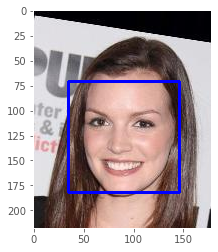

In [2]:
EXAMPLE_PIC = 'celeba-dataset//img_align_celeba//000506.jpg'

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# load color (BGR) image
file_name = EXAMPLE_PIC
img = cv2.imread(file_name)

# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.grid(False)
plt.imshow(cv_rgb)
plt.show()

We include the Attributes data set in order to get characteristics of the images

In [3]:
# import the data set that include the attribute for each picture
df_attr = pd.read_csv('celeba-dataset//list_attr_celeba.csv')
df_attr.set_index('image_id', inplace=True)
df_attr.replace(to_replace=-1, value=0, inplace=True) #replace -1 by 0
df_attr.shape

(202599, 40)

In [4]:
# List of available attributes
for i, j in enumerate(df_attr.columns):
    print(i, j)

0 5_o_Clock_Shadow
1 Arched_Eyebrows
2 Attractive
3 Bags_Under_Eyes
4 Bald
5 Bangs
6 Big_Lips
7 Big_Nose
8 Black_Hair
9 Blond_Hair
10 Blurry
11 Brown_Hair
12 Bushy_Eyebrows
13 Chubby
14 Double_Chin
15 Eyeglasses
16 Goatee
17 Gray_Hair
18 Heavy_Makeup
19 High_Cheekbones
20 Male
21 Mouth_Slightly_Open
22 Mustache
23 Narrow_Eyes
24 No_Beard
25 Oval_Face
26 Pale_Skin
27 Pointy_Nose
28 Receding_Hairline
29 Rosy_Cheeks
30 Sideburns
31 Smiling
32 Straight_Hair
33 Wavy_Hair
34 Wearing_Earrings
35 Wearing_Hat
36 Wearing_Lipstick
37 Wearing_Necklace
38 Wearing_Necktie
39 Young


During this project the focues will be over 3 attributes: <b>Smiling or not, Female or Male and Young or not.</b>

In the example picture, these are the attributes:

Smiling    1
Male       0
Young      1
Name: 000506.jpg, dtype: int64

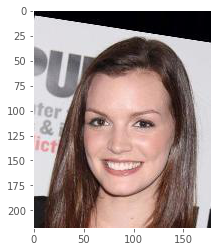

In [5]:
# plot picture and attributes
img = load_img(EXAMPLE_PIC)
plt.grid(False)
plt.imshow(img)
df_attr.loc[EXAMPLE_PIC.split('/')[-1]] [['Smiling','Male','Young']]

In the example picture, according to the data set, the person is smiling, is female and is young.

In [6]:
# Select the attributies for this project
df_attr = df_attr[['Smiling','Male','Young']]
df_attr.head()

,Smiling,Male,Young
image_id,,,
000001.jpg,1,0,1
000002.jpg,1,0,1
000003.jpg,0,1,1
000004.jpg,0,0,1
000005.jpg,0,0,1


### Plot the distribution of the selected attributes

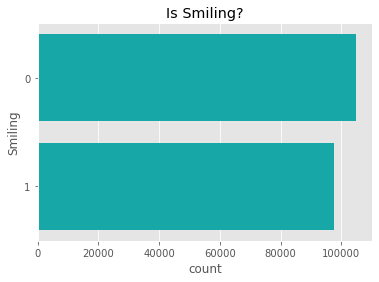

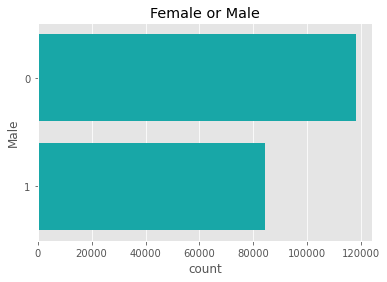

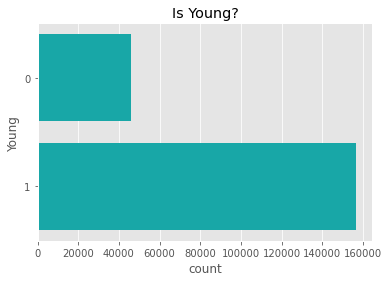

In [7]:
# Plot the selected attributes

# Is Smiling?
plt.title('Is Smiling?')
sns.countplot(y='Smiling', data=df_attr, color="c");
plt.show()

# Female or Male?
plt.title('Female or Male')
sns.countplot(y='Male', data=df_attr, color="c");
plt.show()

# Is Young?
plt.title('Is Young?')
sns.countplot(y='Young', data=df_attr, color="c");
plt.show()

#### Some notes:

* <b>Similing or not</b><br>
The data set is balanced for this attributes.<br><br>

* <b>Female or Male</b><br>
There are more females than males in the data set.<br><br>

* <b>Young or not</b><br>
Most of the people of the images of the data set are young.<br>

This analysis gives us some signs of how balanced the data is, and how to handle the data to train the models with balanced data.

## Step 1: Pre-processing Images: Data Augmentation

Generates Data Augmentation for iamges.

Data Augmentation allows to generate images with modifications to the original ones. The model will learn from these variations (changing angle, size and position), being able to predict better never seen images that could have the same variations in position, size and position.

In [8]:
# Generate image generator for data augmentation
datagen =  ImageDataGenerator(
  preprocessing_function=preprocess_input,
  rotation_range=30,
  width_shift_range=0.2,
  height_shift_range=0.2,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip=True
)

img = load_img(EXAMPLE_PIC)
x = img_to_array(img)
x = x.reshape((1,) + x.shape)

# Delete path if exists
if os.path.exists('celeba-dataset//data_augmentation_sample'):
    shutil.rmtree('celeba-dataset//data_augmentation_sample')

# Create paths for data augmentation sample
os.makedirs('celeba-dataset//data_augmentation_sample')

#create just 10 pics as example
i = 0
for batch in datagen.flow(x, batch_size=1,
              save_to_dir='celeba-dataset//data_augmentation_sample', save_prefix='data_aug', save_format='jpg'):
    if i == 9:
        break
    i += 1

C:\Users\HARSHT~1\AppData\Local\Temp/ipykernel_15796/776434903.py:6: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(len(aug_files) / columns + 1, columns, i + 1)


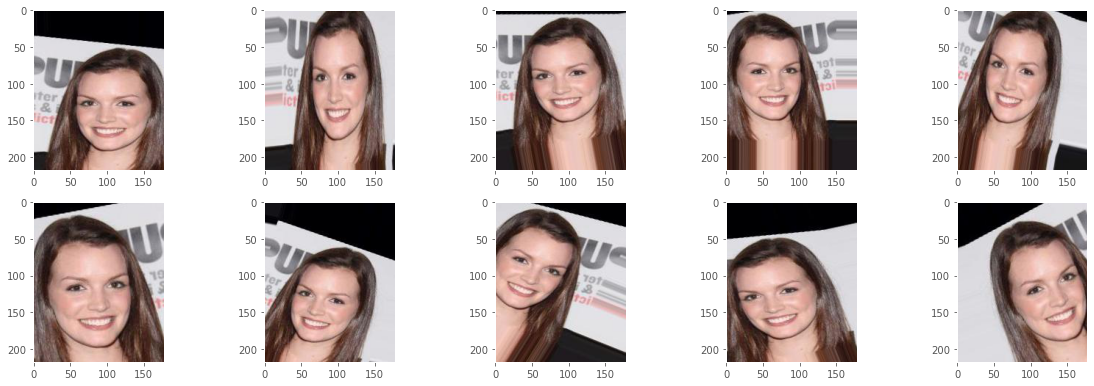

In [9]:
# Display Data Augmentation results
aug_files = glob.glob("celeba-dataset//data_augmentation_sample//*.jpg")
plt.figure(figsize=(20,10))
columns = 5
for i, image in enumerate(aug_files):
    plt.subplot(len(aug_files) / columns + 1, columns, i + 1)
    img = load_img(image)
    plt.grid(False)
    plt.imshow(img)

The result is a new set of images with modifications from the original one, that allows to the model to learn from these variations in order to take this kind of images during the learning process and predict better never seen images.

## Step 2: Split Dataset into Training, Validation and Test

The recommended partitioning of images into training, validation, testing of the data set is: 
* 1-162770 are training
* 162771-182637 are validation
* 182638-202599 are testing


The number of images to be used by each model is:

* Training 20000 images
* Validation 5000 images
* Test 5000 Images


In [10]:
df_partition = pd.read_csv('celeba-dataset//list_eval_partition.csv') #the recommended partition
df_partition.head()

,image_id,partition
0,000001.jpg,0
1,000002.jpg,0
2,000003.jpg,0
3,000004.jpg,0
4,000005.jpg,0


In [11]:
# display counter by partition
# 0 -> TRAINING
# 1 -> VALIDATION
# 2 -> TEST
df_partition['partition'].value_counts().sort_index()

0    162770
1     19867
2     19962
Name: partition, dtype: int64

#### Join the partition and the attributes in the same df

In [12]:
# join the partition with the attributes
df_partition.set_index('image_id', inplace=True)
df_par_attr = df_partition.join(df_attr, how='inner')
df_par_attr.head()

,partition,Smiling,Male,Young
image_id,,,,
000001.jpg,0,1,0,1
000002.jpg,0,1,0,1
000003.jpg,0,0,1,1
000004.jpg,0,0,0,1
000005.jpg,0,0,0,1


## Step 2.1: Create folders with selected images for models

Number of images need to be balanced in order to get a good performance for the model, each model will have its own folder of training, validation and test balanced data.

On this degree projects, is explained how imbalanced training data impact on CNNs models:

https://www.kth.se/social/files/588617ebf2765401cfcc478c/PHensmanDMasko_dkand15.pdf

On this step we will create functions that will help us to create the data set for each model. Functions will be executed on each model step in order to avoid confusions.


In [13]:
# Set Variables
TRAINING_SAMPLES = 20000
VALIDATION_SAMPLES = 5000
TEST_SAMPLES = 5000
IMG_WIDTH = 178
IMG_HEIGHT = 218
BATCH_SIZE = 16
NUM_EPOCHS = 20 #25

In [14]:
def generate_df(attr):
    '''
    select the sub data sets from the recommended partition randomly
    generates balanced data
    
    '''
    
    print('Attribute:', attr)

    df_train = df_par_attr[(df_par_attr['partition'] == 0) & (df_par_attr[attr] == 0)].sample(int(TRAINING_SAMPLES/2)) #file names for training
    df_train = pd.concat([df_train,
                                  df_par_attr[(df_par_attr['partition'] == 0) & (df_par_attr[attr] == 1)].sample(int(TRAINING_SAMPLES/2))]) #file names for training
    print('\ntrain:\n', df_train[attr].value_counts())

    df_val = df_par_attr[(df_par_attr['partition'] == 1) & (df_par_attr[attr] == 0)].sample(int(VALIDATION_SAMPLES/2)) #file names for validation
    df_val = pd.concat([df_val,
                                  df_par_attr[(df_par_attr['partition'] == 1) & (df_par_attr[attr] == 1)].sample(int(VALIDATION_SAMPLES/2))]) #file names for validation
    print('\nvalidation:\n', df_val[attr].value_counts())

    df_test = df_par_attr[(df_par_attr['partition'] == 2) & (df_par_attr[attr] == 0)].sample(int(TEST_SAMPLES/2)) #file names for test
    df_test = pd.concat([df_test,
                                  df_par_attr[(df_par_attr['partition'] == 2) & (df_par_attr[attr] == 1)].sample(int(TEST_SAMPLES/2))]) #file names for test
    print('\ntest:\n', df_test[attr].value_counts())

    return df_train, df_val, df_test

In [15]:
# create folders (train, validation and test) for each model
def create_file_folder(prefix):
    '''
    create folders in order to use the flow_from_directory method form keras
    
    creates folders:
        train/0
        train/1
        validation/0
        validation/1
        test/0
        test/1
        
    '''
    
    list_type_ds = ['train', 'validation', 'test']
    
    # Delete path if exists
    for typ in list_type_ds:
        if os.path.exists('celeba-dataset//{}-{}'.format(prefix, typ)):
            shutil.rmtree('celeba-dataset//{}-{}'.format(prefix, typ))
       
    # Create paths for training, validation and test data
    for typ in list_type_ds:
        os.makedirs('celeba-dataset//{}-{}'.format(prefix, typ))
        os.makedirs('celeba-dataset//{}-{}//0'.format(prefix, typ))
        os.makedirs('celeba-dataset//{}-{}//1'.format(prefix, typ))

#create_file_folder('young')

In [16]:
# copy images to the corresponding folder
def copy_images(folder_prefix, attribute, df_images, df_type):
    '''
    copy images to the corresponding folder (classes)
    
    folder_prefix: expected prefix in folder
    attribute: attribute as in the data set to discriminate the classes
    df_images: data frame with image file name and attributes
    df_type: type of data set, train, validation or test
    
    '''
    
    # Copy images
    for i, j in df_images.iterrows():
        if j[attribute] == 0:
            shutil.copy('celeba-dataset//img_align_celeba//' + i, 'celeba-dataset//{}-{}//0//{}'.format(folder_prefix, df_type, i))
        if j[attribute] == 1:
            shutil.copy('celeba-dataset//img_align_celeba//' + i, 'celeba-dataset//{}-{}//1//{}'.format(folder_prefix, df_type, i))
            
    print("{} {} - Copy Images: DONE!".format(folder_prefix, df_type))       

In [17]:
def count_attributes(prefix, reference_class):
    '''
    count image classes for each model
    
    prefix: expected prefix in folder name
    reference_class: list of str with meaning of each class
    '''
    
    print('\nData for "{}" Model'.format(prefix))
    list_ds_types = ['train', 'validation', 'test']
    
    for ty in list_ds_types:
        print('   {} data:'.format(ty))
        print('      {}:'.format(reference_class[0]), len(os.listdir('celeba-dataset//{}-{}//0//'.format(prefix, ty))))
        print('      {}:'.format(reference_class[1]), len(os.listdir('celeba-dataset//{}-{}//1//'.format(prefix, ty))))


With the data in their respective folders, we are ready to start modeling.

## Step 3: "Smiling or not" Model

### 3.1. Set the Smile Model

In [44]:
create_file_folder('smile')
print('Generate dataframe with file names for the model')
df_smile_train, df_smile_val, df_smile_test = generate_df('Smiling')
print('\nCopying the images...')
copy_images('smile', 'Smiling', df_smile_train, 'train')
copy_images('smile', 'Smiling', df_smile_val, 'validation')
copy_images('smile', 'Smiling', df_smile_test, 'test')
print('Counter from file')
count_attributes('smile', ['Not Smiling', 'Smiling'])

Generate dataframe with file names for the model
Attribute: Smiling

train:
 0    10000
1    10000
Name: Smiling, dtype: int64

validation:
 0    2500
1    2500
Name: Smiling, dtype: int64

test:
 0    2500
1    2500
Name: Smiling, dtype: int64

Copying the images...
smile train - Copy Images: DONE!
smile validation - Copy Images: DONE!
smile test - Copy Images: DONE!
Counter from file

Data for "smile" Model
   train data:
      Not Smiling: 10000
      Smiling: 10000
   validation data:
      Not Smiling: 2500
      Smiling: 2500
   test data:
      Not Smiling: 2500
      Smiling: 2500


In [45]:
PREFIX = 'smile'

In [46]:
# Data Preparation - Data Augmentation with generators
train_datagen =  ImageDataGenerator(
  preprocessing_function=preprocess_input,
  rotation_range=30,
  width_shift_range=0.2,
  height_shift_range=0.2,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip=True
)

valid_datagen = ImageDataGenerator(
  preprocessing_function=preprocess_input,
  rotation_range=30,
  width_shift_range=0.2,
  height_shift_range=0.2,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
'celeba-dataset//{}-train'.format(PREFIX),
target_size=(IMG_HEIGHT, IMG_WIDTH),
batch_size=BATCH_SIZE,
)

validation_generator = valid_datagen.flow_from_directory(
'celeba-dataset//{}-validation'.format(PREFIX),
target_size=(IMG_HEIGHT, IMG_WIDTH),
class_mode='categorical'
)

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [47]:
# Import InceptionV3 Model
inc_model = InceptionV3(weights='imagenet',
                  include_top=False,
                    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
print("number of layers:", len(inc_model.layers))
inc_model.summary()

number of layers: 311
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 218, 178, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 108, 88, 32)  864         ['input_2[0][0]']                
                                                                                                  
 batch_normalization_94 (BatchN  (None, 108, 88, 32)  96         ['conv2d_94[0][0]']              
 ormalization)                                                                                    
                                                                 

 batch_normalization_104 (Batch  (None, 24, 19, 96)  288         ['conv2d_104[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_105 (Batch  (None, 24, 19, 32)  96          ['conv2d_105[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_99 (Activation)     (None, 24, 19, 64)   0           ['batch_normalization_99[0][0]'] 
                                                                                                  
 activation_101 (Activation)    (None, 24, 19, 64)   0           ['batch_normalization_101[0][0]']
                                                                                                  
 activatio

 conv2d_114 (Conv2D)            (None, 24, 19, 48)   13824       ['mixed1[0][0]']                 
                                                                                                  
 conv2d_117 (Conv2D)            (None, 24, 19, 96)   55296       ['activation_116[0][0]']         
                                                                                                  
 batch_normalization_114 (Batch  (None, 24, 19, 48)  144         ['conv2d_114[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_117 (Batch  (None, 24, 19, 96)  288         ['conv2d_117[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activatio

                                                                                                  
 conv2d_128 (Conv2D)            (None, 11, 9, 128)   98304       ['mixed3[0][0]']                 
                                                                                                  
 batch_normalization_128 (Batch  (None, 11, 9, 128)  384         ['conv2d_128[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_128 (Activation)    (None, 11, 9, 128)   0           ['batch_normalization_128[0][0]']
                                                                                                  
 conv2d_129 (Conv2D)            (None, 11, 9, 128)   114688      ['activation_128[0][0]']         
                                                                                                  
 batch_nor

                                                                                                  
 activation_138 (Activation)    (None, 11, 9, 160)   0           ['batch_normalization_138[0][0]']
                                                                                                  
 conv2d_139 (Conv2D)            (None, 11, 9, 160)   179200      ['activation_138[0][0]']         
                                                                                                  
 batch_normalization_139 (Batch  (None, 11, 9, 160)  480         ['conv2d_139[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_139 (Activation)    (None, 11, 9, 160)   0           ['batch_normalization_139[0][0]']
                                                                                                  
 conv2d_13

 batch_normalization_149 (Batch  (None, 11, 9, 160)  480         ['conv2d_149[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_149 (Activation)    (None, 11, 9, 160)   0           ['batch_normalization_149[0][0]']
                                                                                                  
 conv2d_145 (Conv2D)            (None, 11, 9, 160)   122880      ['mixed5[0][0]']                 
                                                                                                  
 conv2d_150 (Conv2D)            (None, 11, 9, 160)   179200      ['activation_149[0][0]']         
                                                                                                  
 batch_normalization_145 (Batch  (None, 11, 9, 160)  480         ['conv2d_145[0][0]']             
 Normaliza

 conv2d_155 (Conv2D)            (None, 11, 9, 192)   147456      ['mixed6[0][0]']                 
                                                                                                  
 conv2d_160 (Conv2D)            (None, 11, 9, 192)   258048      ['activation_159[0][0]']         
                                                                                                  
 batch_normalization_155 (Batch  (None, 11, 9, 192)  576         ['conv2d_155[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_160 (Batch  (None, 11, 9, 192)  576         ['conv2d_160[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activatio

 Normalization)                                                                                   
                                                                                                  
 batch_normalization_168 (Batch  (None, 11, 9, 192)  576         ['conv2d_168[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_164 (Activation)    (None, 11, 9, 192)   0           ['batch_normalization_164[0][0]']
                                                                                                  
 activation_168 (Activation)    (None, 11, 9, 192)   0           ['batch_normalization_168[0][0]']
                                                                                                  
 conv2d_165 (Conv2D)            (None, 5, 4, 320)    552960      ['activation_164[0][0]']         
          

                                                                                                  
 activation_176 (Activation)    (None, 5, 4, 384)    0           ['batch_normalization_176[0][0]']
                                                                                                  
 activation_177 (Activation)    (None, 5, 4, 384)    0           ['batch_normalization_177[0][0]']
                                                                                                  
 batch_normalization_178 (Batch  (None, 5, 4, 192)   576         ['conv2d_178[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_170 (Activation)    (None, 5, 4, 320)    0           ['batch_normalization_170[0][0]']
                                                                                                  
 mixed9_0 

 Normalization)                                                                                   
                                                                                                  
 activation_179 (Activation)    (None, 5, 4, 320)    0           ['batch_normalization_179[0][0]']
                                                                                                  
 mixed9_1 (Concatenate)         (None, 5, 4, 768)    0           ['activation_181[0][0]',         
                                                                  'activation_182[0][0]']         
                                                                                                  
 concatenate_3 (Concatenate)    (None, 5, 4, 768)    0           ['activation_185[0][0]',         
                                                                  'activation_186[0][0]']         
                                                                                                  
 activatio

In [48]:
#Adding custom Layers
x = inc_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(512, activation="relu")(x)
predictions = Dense(2, activation="softmax")(x)

In [49]:
# creating the final model 
model_smile = Model(inputs=inc_model.input, outputs=predictions)

# Lock initial layers to do not be trained
for layer in model_smile.layers[:52]:
    layer.trainable = False

# compile the model
model_smile.compile(optimizer=SGD(learning_rate=0.0001, momentum=0.9)
                    , loss='categorical_crossentropy'
                    , metrics=['accuracy'])

### 3.2. Train Smile Model

In [50]:
#https://keras.io/models/sequential/ fit generator
checkpointer = ModelCheckpoint(filepath='new_saved_models/copy_weights.best.inc.smile.hdf5', 
                               verbose=1, save_best_only=True)

In [51]:
train_generator

In [52]:
model_smile.fit(train_generator, validation_data = validation_generator, steps_per_epoch= TRAINING_SAMPLES/BATCH_SIZE, epochs= 5, callbacks=[checkpointer])

Epoch 1/5
  21/1250 [..............................] - ETA: 1:12:35 - loss: 0.7476 - accuracy: 0.5000

KeyboardInterrupt: 

The best model after NUM_epech got an accuracy over the validation data of XXX%.

### 3.3. Model Evaluation

In [26]:
#load the best model
model_smile.load_weights('saved_models/weights.best.inc.smile.hdf5')

In [30]:
# Generate test files
def generate_test_data(prefix):
    '''
    Resized pictures to the expected array by the model.
    Converts images to arrays.
    
    return
        x_test: list of array of images.
        y_test: list of labels of the images
    '''
    
    x_test = []
    y_test = []

    for i in [0,1]:
        for j in glob.glob("celeba-dataset/{}-test/{}/*.jpg".format(prefix, i)):
            im = cv2.imread(j.replace('\\','/'))
            im = cv2.resize(cv2.cvtColor(im, cv2.COLOR_BGR2RGB), (IMG_WIDTH, IMG_HEIGHT)).astype(np.float32) / 255.0
            im = np.expand_dims(im, axis =0)
            x_test.append(im)
            y_test.append(i)

    return x_test, y_test

x_smile_test, y_smile_test = generate_test_data('smile')

In [28]:
# generate prediction
model_predictions = [np.argmax(model_smile.predict(feature)) for feature in x_smile_test ]

# report test accuracy
test_accuracy = 100 * np.sum(np.array(model_predictions)==y_smile_test) / len(model_predictions)
print('Smile Model')
print('Test accuracy: %.4f%%' % test_accuracy)
print('f1_score:', f1_score(y_smile_test, model_predictions))

Smile Model
Test accuracy: 91.3800%
f1_score: 0.9136791508111355


In [50]:
model_smile.save('saved_models/smile_model.h5')

## Step 4: "Female or Male" Model

### 4.1. Set the "Female or Male" Model

In [22]:
create_file_folder('gender')

print('Generate dataframe with file names for the model')
df_gender_train, df_gender_val, df_gender_test = generate_df('Male')
print('\nCopying the images...')
copy_images('gender', 'Male', df_gender_train, 'train')
copy_images('gender', 'Male', df_gender_val, 'validation')
copy_images('gender', 'Male', df_gender_test, 'test')
print('Counter from file')
count_attributes('gender', ['Female', 'Male'])

Generate dataframe with file names for the model
Attribute: Male

train:
 0    10000
1    10000
Name: Male, dtype: int64

validation:
 0    2500
1    2500
Name: Male, dtype: int64

test:
 0    2500
1    2500
Name: Male, dtype: int64

Copying the images...
gender train - Copy Images: DONE!
gender validation - Copy Images: DONE!
gender test - Copy Images: DONE!
Counter from file

Data for "gender" Model
   train data:
      Female: 10000
      Male: 10000
   validation data:
      Female: 2500
      Male: 2500
   test data:
      Female: 2500
      Male: 2500


In [23]:
PREFIX = 'gender'

In [24]:
#set the data generator
train_generator = train_datagen.flow_from_directory(
'celeba-dataset/{}-train'.format(PREFIX),
target_size=(IMG_HEIGHT, IMG_WIDTH),
batch_size=BATCH_SIZE,
)

validation_generator = valid_datagen.flow_from_directory(
'celeba-dataset/{}-validation'.format(PREFIX),
target_size=(IMG_HEIGHT, IMG_WIDTH),
class_mode='categorical'
)

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [25]:
# creating the final model 
model_gender = Model(inputs=inc_model.input, outputs=predictions)

# Lock initial layers to do not be trained
for layer in model_gender.layers[:52]:
    layer.trainable = False

# compile the model
model_gender.compile(optimizer=SGD(learning_rate=0.0001, momentum=0.9)
                    , loss='categorical_crossentropy'
                    , metrics=['accuracy'])

### 4.2. Train Gender Model

In [27]:
#https://keras.io/models/sequential/ fit generator
gender_checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.inc.gender.hdf5', 
                               verbose=1, save_best_only=True)

model_gender.fit(train_generator, validation_data = validation_generator, steps_per_epoch= TRAINING_SAMPLES/BATCH_SIZE
                , epochs= 5, callbacks=[gender_checkpointer], verbose=1)

Epoch 1/5
1250/1250 [==============================] - ETA: 0s - loss: 0.4118 - accuracy: 0.8100
Epoch 1: val_loss improved from inf to 0.20429, saving model to saved_models\weights.best.inc.gender.hdf5
1250/1250 [==============================] - 1501s 1s/step - loss: 0.4118 - accuracy: 0.8100 - val_loss: 0.2043 - val_accuracy: 0.9224
Epoch 2/5
1250/1250 [==============================] - ETA: 0s - loss: 0.2529 - accuracy: 0.8983
Epoch 2: val_loss improved from 0.20429 to 0.14570, saving model to saved_models\weights.best.inc.gender.hdf5
1250/1250 [==============================] - 1474s 1s/step - loss: 0.2529 - accuracy: 0.8983 - val_loss: 0.1457 - val_accuracy: 0.9456
Epoch 3/5
1250/1250 [==============================] - ETA: 0s - loss: 0.2047 - accuracy: 0.9207
Epoch 3: val_loss improved from 0.14570 to 0.11629, saving model to saved_models\weights.best.inc.gender.hdf5
1250/1250 [==============================] - 1447s 1s/step - loss: 0.2047 - accuracy: 0.9207 - val_loss: 0.1163 -

### 4.3. Model Evaluation

In [28]:
#load the best model
model_gender.load_weights('saved_models/weights.best.inc.gender.hdf5')

In [31]:
x_gender_test, y_gender_test = generate_test_data('gender')

In [32]:
# generate prediction
model_predictions = [np.argmax(model_gender.predict(feature)) for feature in x_gender_test ]

# report test accuracy
test_accuracy = 100 * np.sum(np.array(model_predictions)==y_gender_test) / len(model_predictions)
print('Gender Model')
print('Test accuracy: %.4f%%' % test_accuracy)
print('f1_score:', f1_score(y_gender_test, model_predictions))

1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - 0s 49ms/step


1/1 [==============================] - 0s 46ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 46ms/step


1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - 0s 46ms/step


1/1 [==============================] - 0s 61ms/step


1/1 [==============================] - 0s 51ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 51ms/step


1/1 [==============================] - 0s 53ms/step


1/1 [==============================] - 0s 64ms/step


1/1 [==============================] - 0s 56ms/step


1/1 [==============================] - 0s 59ms/step


1/1 [==============================] - 0s 60ms/step
Gender Model
Test accuracy: 95.4400%
f1_score: 0.9550650374458022


In [33]:
model_gender.save('saved_models/new_gender_model.h5')

## Step 5: "Young or not" Model

### 5.1. Set the "Young or not" Model

In [34]:
create_file_folder('young')

print('Generate dataframe with file names for the model')
df_young_train, df_young_val, df_young_test = generate_df('Young')
print('\nCopying the images...')
copy_images('young', 'Young', df_young_train, 'train')
copy_images('young', 'Young', df_young_val, 'validation')
copy_images('young', 'Young', df_young_test, 'test')
print('Counter from file')
count_attributes('young', ['Not Young', 'Young'])

Generate dataframe with file names for the model
Attribute: Young

train:
 0    10000
1    10000
Name: Young, dtype: int64

validation:
 0    2500
1    2500
Name: Young, dtype: int64

test:
 0    2500
1    2500
Name: Young, dtype: int64

Copying the images...
young train - Copy Images: DONE!
young validation - Copy Images: DONE!
young test - Copy Images: DONE!
Counter from file

Data for "young" Model
   train data:
      Not Young: 10000
      Young: 10000
   validation data:
      Not Young: 2500
      Young: 2500
   test data:
      Not Young: 2500
      Young: 2500


In [35]:
PREFIX = 'young'

In [36]:
#set the data generator
train_generator = train_datagen.flow_from_directory(
'celeba-dataset/{}-train'.format(PREFIX),
target_size=(IMG_HEIGHT, IMG_WIDTH),
batch_size=BATCH_SIZE,
)

validation_generator = valid_datagen.flow_from_directory(
'celeba-dataset/{}-validation'.format(PREFIX),
target_size=(IMG_HEIGHT, IMG_WIDTH),
class_mode='categorical'
)

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [37]:
# creating the final model 
model_young = Model(inputs=inc_model.input, outputs=predictions)

# Lock initial layers to do not be trained
for layer in model_young.layers[:52]:
    layer.trainable = False

# compile the model
model_young.compile(optimizer=SGD(learning_rate=0.0001, momentum=0.9)
                    , loss='categorical_crossentropy'
                    , metrics=['accuracy'])

### 5.2. Train Young or Not Model

In [54]:
#https://keras.io/models/sequential/ fit generator
young_checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.inc.young.hdf5', 
                               verbose=1, save_best_only=True)

model_young.fit_generator(train_generator, validation_data = validation_generator, steps_per_epoch= TRAINING_SAMPLES/BATCH_SIZE
                          , epochs= NUM_EPOCHS, callbacks=[young_checkpointer], verbose=1)

Epoch 1/20
1250/1250 [==============================] - 632s 506ms/step - loss: 0.2629 - acc: 0.8870 - val_loss: 0.5306 - val_acc: 0.7802

Epoch 00001: val_loss improved from inf to 0.53057, saving model to saved_models/weights.best.inc.young.hdf5
Epoch 2/20
1250/1250 [==============================] - 630s 504ms/step - loss: 0.2553 - acc: 0.8906 - val_loss: 0.4898 - val_acc: 0.7978

Epoch 00002: val_loss improved from 0.53057 to 0.48979, saving model to saved_models/weights.best.inc.young.hdf5
Epoch 3/20
1250/1250 [==============================] - 618s 495ms/step - loss: 0.2558 - acc: 0.8892 - val_loss: 0.5621 - val_acc: 0.7762

Epoch 00003: val_loss did not improve from 0.48979
Epoch 4/20
1250/1250 [==============================] - 618s 494ms/step - loss: 0.2423 - acc: 0.8964 - val_loss: 0.5674 - val_acc: 0.7780

Epoch 00004: val_loss did not improve from 0.48979
Epoch 5/20
1250/1250 [==============================] - 618s 494ms/step - loss: 0.2423 - acc: 0.8939 - val_loss: 0.5344 

### 5.3. Model Evaluation

In [55]:
#load the best model
model_young.load_weights('saved_models/weights.best.inc.young.hdf5')

In [43]:
x_young_test, y_young_test = generate_test_data('young')

In [44]:
# generate prediction
model_predictions = [np.argmax(model_young.predict(feature)) for feature in x_young_test ]

# report test accuracy
test_accuracy = 100 * np.sum(np.array(model_predictions)==y_young_test) / len(model_predictions)
print('Young or Not Model')
print('Test accuracy: %.4f%%' % test_accuracy)
print('f1_score:', f1_score(y_young_test, model_predictions))

Young or Not Model
Test accuracy: 82.0600%
f1_score: 0.8181633894182041


In [56]:
model_young.save('saved_models/young_model.h5')